**Dataset :** https://gitlab.com/our-sci/real-food-campaign/rfc-docs/-/blob/master/2020/dataset/cleaned3.csv (4518, 4053)

As you saw in the other notebook, outliers have a significant impact on our models' performance. In this notebook, we try to see if we can detect or predict them using the features in the dataset.

In [1]:
%load_ext autoreload
%autoreload 2

import nbimporter

import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import missingno as msno
sns.set_theme(style = 'darkgrid')

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import classification_report

from scipy.stats import ks_2samp

from methods import  outliers_column, plot_forest_importances, compute_forest_importance,qualitative_outliers_plot, \
preprocess_and_evaluate, compute_perf_sampling, plot_perf_sampling, remove_NaN_columns

In [2]:
data = pd.read_csv('Data2020/cleaned3.csv', low_memory=False)

In [3]:
targets = ['polyphenols_final', 'antioxidants_final', 'brix']
surface_cols = [X for X in data.columns if 'surface.scan' in X]
juice_cols = [X for X in data.columns if 'juice.scan' in X]

cols = surface_cols + juice_cols + targets + ['sample_type']
df = data[cols]

In [4]:
df = df.copy()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Replace infinite values by NaN

# Replace sample type name
def replace_bok(x):
    if x == 'bok_choy_bok_choi_pak_choy':
        return 'bok_choy'
    else:
        return x
df['sample_type'] = df['sample_type'].apply(replace_bok)

In [5]:
df['outliers'] = outliers_column(df, targets)
data['outliers'] = outliers_column(data, targets)

We defined an outliers column based on the interquartile range. For each target, we check if the value of the row is upper than $Q3 + 1.5 * (Q3-Q1)$ or lesser than $Q1 - 1.5 * (Q3-Q1)$. If it is true for one of the targets, the row is then considered as an outlier.

# Outliers analysis

## Outliers on targets

In [6]:
temp = df.copy()
for elem in targets:
    temp['temp'] = temp[elem] >= temp[elem].quantile(.75) + 1.5*(temp[elem].quantile(.75) - \
                                                                 temp[elem].quantile(.25))
    print(elem,':', temp['temp'].sum(), 'outliers')

polyphenols_final : 181 outliers
antioxidants_final : 210 outliers
brix : 77 outliers


If you saw the results of the models' predictions, you might have noticed that the targets where the models struggle the most are the targets with the more outliers.

### On the sub dataset

We create a Random Forest classifier that tries to predict if a value is an outlier or not (the targets are excluded from the features). Then we can analyse which features allow us to detect outliers.

In [7]:
subdf = df.dropna(axis = 0)
target_o = subdf['outliers']
features_o = subdf.drop(['outliers']+targets, axis = 1)

We can print the results of the model :

In [8]:
model_o, feat, encoder = preprocess_and_evaluate(target_o, features_o)

              precision    recall  f1-score   support

       False       0.93      0.98      0.95       422
        True       0.72      0.43      0.54        53

    accuracy                           0.92       475
   macro avg       0.83      0.71      0.75       475
weighted avg       0.91      0.92      0.91       475



The model has a pretty low recall but a pretty good prediction. It means that the model does not classifies a lot of outliers as outliers, but when it does it is mostly correct. But this is not what interest us the most here.

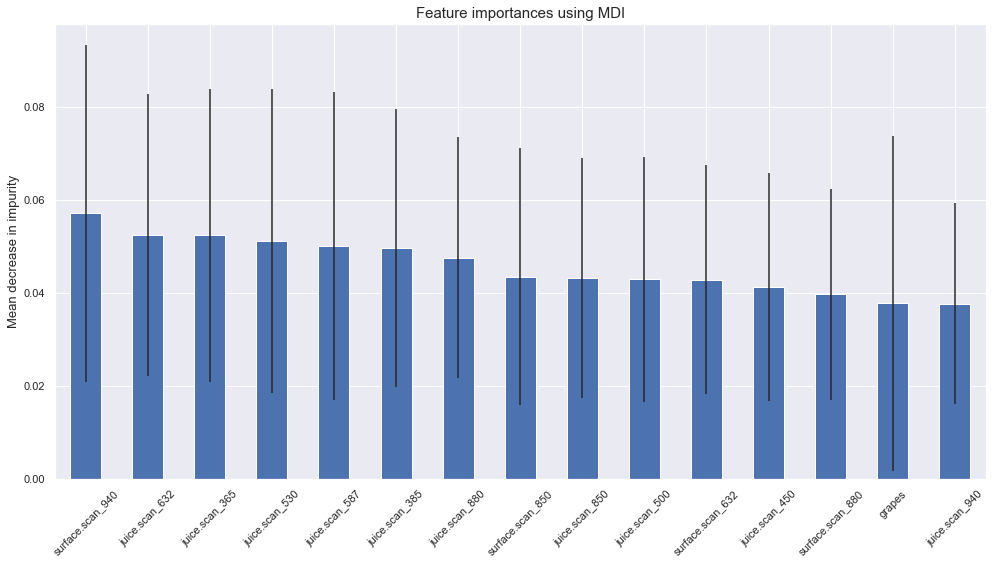

In [9]:
feat_names = feat[:-1] + list(encoder.categories_[0])
forest_importances, std = compute_forest_importance(model_o, feat_names)
plot_forest_importances(forest_importances, std, 15)

According to those results, we cannot explain the presence of outliers with the variables of the subdataset (the MDI is too low).

### On the whole dataset

In [10]:
data = data.dropna(subset = targets, axis = 0)
data.replace([np.inf, -np.inf], np.nan, inplace=True)

#### Numeric columns

The first method is to do the same thing as before, which means create a Random Forest Classifier that tries to predict if a value is an outlier or not and then plot the most important features.

In [11]:
num_data = data.select_dtypes(include = np.number)
num_data = remove_NaN_columns(num_data, .8) # We remove columns where the % of NaN is >= than 80%

num_X = num_data[[X for X in num_data.columns \
                  if 'antioxidants' not in X.lower() and 'brix' not in X.lower() and 'polyphenols' not in X.lower()]]
num_y = data['outliers']

In [12]:
imputer = KNNImputer(n_neighbors = 10)

In [13]:
# Model definition
model = RandomForestClassifier(n_estimators = 1000, criterion = 'gini', random_state = 0)

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(num_X, num_y, test_size = .2, random_state=0)

# Imputer
imputer.fit(X_train)
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Model fitting and prediction
model.fit(X_train_imputed, y_train)
y_hat = model.predict(X_test_imputed)

In [14]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

       False       0.92      0.97      0.95       439
        True       0.71      0.43      0.53        63

    accuracy                           0.91       502
   macro avg       0.82      0.70      0.74       502
weighted avg       0.90      0.91      0.90       502



The results here are pretty much the same as the model we trained on the sub dataset

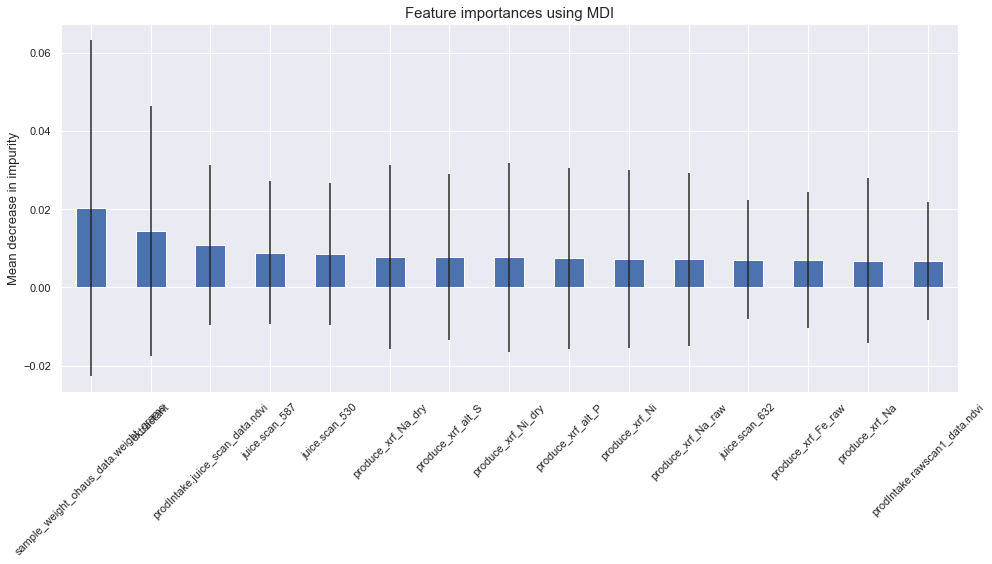

In [15]:
feat_names = list(num_X.columns)
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
std = pd.Series(std, index = feat_names)
forest_importances, std = compute_forest_importance(model, feat_names)
plot_forest_importances(forest_importances, std, 15)

The second method is to compute a non parametric test called the [Kolmogorov-Smirnov test](https://towardsdatascience.com/how-to-compare-two-distributions-in-practice-8c676904a285) that allows us to compare two distributions. In our case, we want to know if the distribution for a variable is the same whether we are in an "outlier case" or not. If not, it means that the feature can be used to understand when an "outlier case" occurs.

In [16]:
num_data = num_data.copy()
num_data['outliers'] = data['outliers']

Kolmogorov-Smirnov test is a non parametric test, thus we can use it to compare non normal distributions. We first compute the critical value. The formula is the following :

$\Large D_{\alpha} = c(\alpha)\sqrt{\frac{n_1+n_2}{n_1.n_2}}$

$c(\alpha)$ is equal to $1.36$ if we choose a level of signifiance of 5% (what we did), and $n_1$ and $n_2$ are the sizes of our two samples.

We then compute the Kolmogorov-Smirnov statistic using scipy and we compare it with the critical value. If the statistic is greater than the critical value and the p-value of the test is lesser than 5 %, we conclude that the distributions are differents. In our case it means that the distribution for a feature is not the same when we are in an outlier case and not.

In [17]:
print("Columns where the outlier/non outlier distributions are differents : ".center(20))
c = 0
for elm in num_data.columns:
    f = num_data[num_data['outliers'] == False]
    t = num_data[num_data['outliers'] == True]
    f = f[elm].dropna()
    t = t[elm].dropna()
    if f.shape[0] > 0 and t.shape[0] > 0:
        crit_value = 1.36*np.sqrt((f.shape[0]+t.shape[0])/f.shape[0]*t.shape[0])
        stat, p = ks_2samp(f, t)
        if stat > crit_value and p <= 0.05:
            print('> ',elem)
            c += 1
if c == 0:
    print('> None')

Columns where the outlier/non outlier distributions are differents : 
> None


It seems that none of the numeric columns can help us to understand whether we are in a case of outlier.

#### Non numeric columns

In [18]:
qual_data = data.select_dtypes(exclude = np.number)
qual_data = remove_NaN_columns(qual_data, .8)
qual_data.shape

(2508, 241)

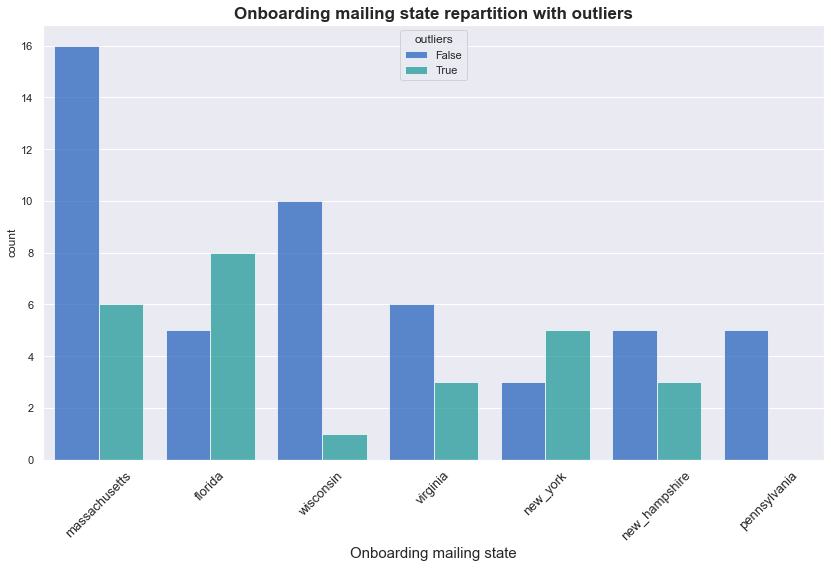

In [19]:
qualitative_outliers_plot(df = data.dropna(axis = 0, subset = ['onboarding.mailing.state']),
                          title = ['Onboarding mailing state repartition with outliers'], 
                          qual_col = ['onboarding.mailing.state'], 
                          outlier_col = 'outliers',
                          xlabel = ['Onboarding mailing state'],
                          palette = 'winter')

On the non numeric columns, it seems that the regions from where the sample were sent to the laboratory can give us an insight on the presence of outliers. However we need more data to check if this hypothesis is true.

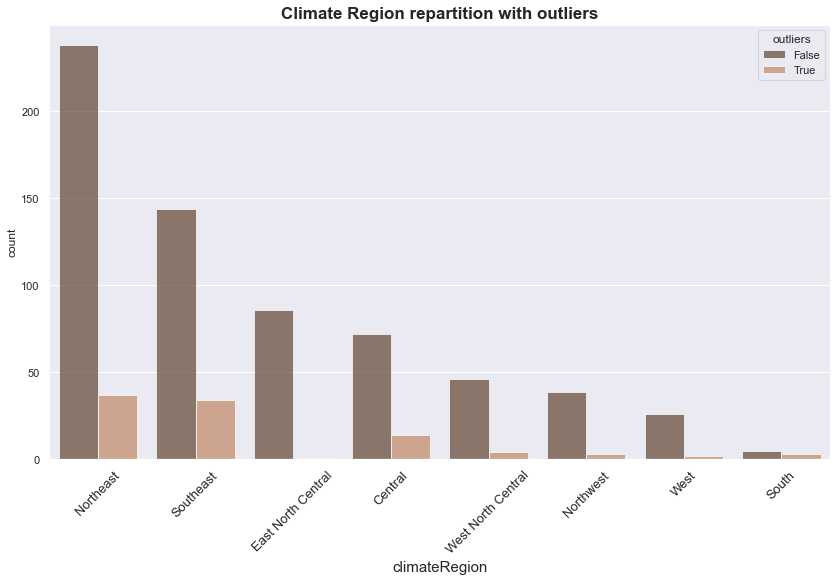

In [20]:
qualitative_outliers_plot(df = data.dropna(axis = 0, subset = ['climateRegion']),
                          title = ['Climate Region repartition with outliers'], 
                          qual_col = ['climateRegion'], 
                          outlier_col = 'outliers',
                          xlabel = ['climateRegion'],
                          palette = 'copper')

On this plot we can see that the climate Region can also help us with the outliers. It seems that samples that come from the region "East North Central" are never outliers.

We didn't find really how to predict outliers by a lack of time. I think that there is no feature in the dataset that is truly correlated with the fact that the sample is an outlier or not. However, some features can help us to understand when we are in a non-outlier case (the climate region for instance). It will need further analysis to confirm or deny this hypothesis. 